# Helmet mapping + FairMOT

In [1]:
# Developer

%cd /kaggle
from IPython.display import clear_output
pat = input('GitHub Personal Access Token:')
clear_output()
! git clone https://$pat@github.com/qAp/nfl_helmet_assignment_kaggle.git

Cloning into 'nfl_helmet_assignment_kaggle'...
remote: Enumerating objects: 176, done.
remote: Counting objects: 100% (176/176), done.
remote: Compressing objects: 100% (126/126), done.
remote: Total 176 (delta 75), reused 142 (delta 41), pack-reused 0
Receiving objects: 100% (176/176), 33.21 KiB | 739.00 KiB/s, done.
Resolving deltas: 100% (75/75), done.


In [ ]:
# %cd /kaggle/nfl_helmet_assignment_kaggle/
# ! git pull

In [ ]:
# # User

# ! cp -r /kaggle/input/nfl-helmet-assignment-kaggle/nfl_helmet_assignment_kaggle /kaggle/.

In [2]:
import os, sys
from tqdm.auto import tqdm
import multiprocessing
import random
import numpy as np
import pandas as pd
import cv2
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import Video, display

sys.path.append('/kaggle/input/easydict-master/easydict-master')
sys.path.append(
    ('/kaggle/input/yolov5-deepsort-pytorch/Yolov5_DeepSort_Pytorch-master'
     '/Yolov5_DeepSort_Pytorch-master/deep_sort_pytorch')
)
sys.path.append('/kaggle/nfl_helmet_assignment_kaggle/')

from helmet_tracker.utils.score import check_submission, NFLAssignmentScorer
from helmet_tracker.utils.features import add_track_features
from helmet_tracker.utils.video import video_with_predictions

In [ ]:
# import importlib
# import helmet_tracker
# importlib.reload(helmet_tracker.models.deepsort_postprocess)

# Loading helmet tracking data

Load the results of helmet tracking, from https://www.kaggle.com/jackchungchiehyu/nfl-helmet-mapping.

In [5]:
debug = False

BASE_DIR = '/kaggle/input/nfl-health-and-safety-helmet-assignment'

labels = pd.read_csv(f'{BASE_DIR}/train_labels.csv')

if debug:
    video_dir = '/kaggle/input/nfl-health-and-safety-helmet-assignment/train'
    submission_df = pd.read_csv('/kaggle/input/nfl-mydata/submission_helmtrack_debug.csv')
else:
    video_dir = '/kaggle/input/nfl-health-and-safety-helmet-assignment/test'
    submission_df = pd.read_csv('/kaggle/input/nfl-mydata/submission_helmtrack.csv')
    dir_demo = '/kaggle/input/nfl05-fairmot-demo/demos'

# Load FairMOT tracking results

In [6]:
submission_df['video'] = submission_df['video_frame'].str.split('_').str[:3].str.join('_')
submission_df['frame'] = submission_df['video_frame'].str.split('_').str[-1].astype(int)

In [7]:
video = submission_df['video'].unique()[3]

In [8]:
def load_results_txt(pth='results.txt', video_width=1280, video_height=720):
    '''
    Load tracking results for a video.
    '''
    fairmot_video_width = 1920
    fairmot_video_height = 1080
    x_scale = video_width / fairmot_video_width
    y_scale = video_height / fairmot_video_height
    
    columns = ['frame', 'id', 'x1', 'y1', 'w', 'h']

    df = pd.read_csv(pth, header=None, 
                     usecols=range(len(columns)), names=columns)
    
    df[['x1', 'w']] = x_scale * df[['x1', 'w']] 
    df[['y1', 'h']] = y_scale * df[['y1', 'h']]
    
    df = df[['frame', 'x1', 'y1', 'w', 'h', 'id']]
    
    df.rename(columns={'x1': 'left', 
                       'y1': 'top', 
                       'w' : 'width',
                       'h' : 'height', 
                       'id': 'fairmot_cluster'}, inplace=True)
    
    for column in ['left', 'top', 'width', 'height']:
        df[column] = df[column].astype(int)
    
    return df

Check loaded FairMOT tracks make sense for a given frame.

In [9]:
pth_tracks_fairmot = os.path.join(dir_demo, video, 'results.txt')
pth_video = os.path.join(video_dir, f'{video}.mp4')
pth_tracks_fairmot, pth_video

('/kaggle/input/nfl05-fairmot-demo/demos/57995_000109_Sideline/results.txt',
 '/kaggle/input/nfl-health-and-safety-helmet-assignment/test/57995_000109_Sideline.mp4')

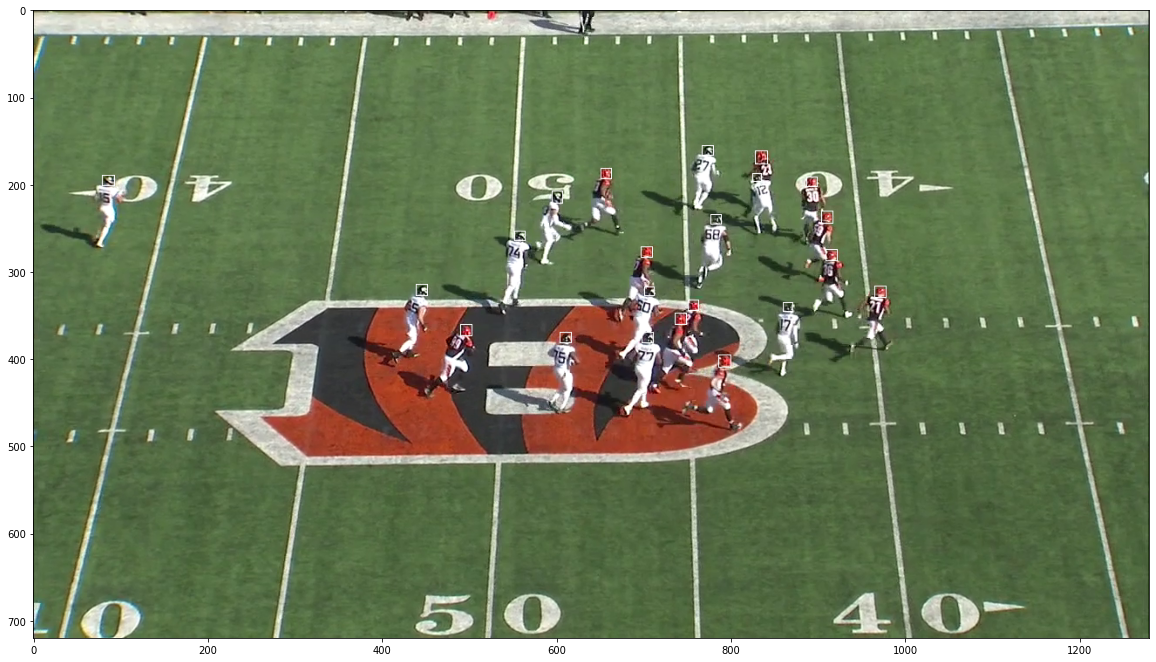

In [10]:
frame = 265


cap = cv2.VideoCapture(pth_video)
fps    = cap.get(cv2.CAP_PROP_FPS)
width  = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)

df_tracks_fairmot = load_results_txt(pth_tracks_fairmot, 
                                     video_width=width, video_height=height)

for _ in range(frame):
    read_ok, img = cap.read()
    assert read_ok
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

for box in df_tracks_fairmot.query("frame==@frame").itertuples():
    x1 = box.left
    y1 = box.top
    x2 = x1 + box.width
    y2 = y1 + box.height
    img = cv2.rectangle(img, 
                        pt1=(x1, y1), pt2=(x2, y2), 
                        color=(255, 255, 255), thickness=1)
    
_, ax = plt.subplots(figsize=(20, 15))
ax.imshow(img);

# Merge helmet-tracking tracks with FairMOT tracks

In [11]:
submission_df['video'] = submission_df['video_frame'].str.split('_').str[:3].str.join('_')
submission_df['frame'] = submission_df['video_frame'].str.split('_').str[-1].astype(int)

In [12]:
video = submission_df['video'].unique()[3]

pth_video = os.path.join(video_dir, f'{video}.mp4')
pth_tracks_fairmot = os.path.join(dir_demo, video, 'results.txt')

df_tracks_helmtrack = submission_df.query('video == @video')

cap = cv2.VideoCapture(pth_video)
video_width  = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
video_height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
df_tracks_fairmot = load_results_txt(pth_tracks_fairmot, 
                                     video_width, video_height)

In [14]:
def merge_tracks(tracks_left, tracks_right, suffix_right='_fairmot'):
    '''
    For a video, merge two sets of tracks by matching their 
    bounding boxes' top-left corner's x-coordinate.
    
    Args:
        tracks_left: pd.DataFrame
            Left set of tracks, with columns like `frame`, `left`, `top`, etc.
        tracks_right: pd.DataFrame
            Right set of tracks, with columns like `frame`, `left`, `top`, etc.
        suffix_right: str
            Suffix that will be added to columns in `tracks_right` that are also
            present in `tracks_left` after the merge.
    '''
    df_tracks = []
    for frame, df_left in tqdm(tracks_left.groupby('frame'), 
                               total=tracks_left['frame'].nunique()):

        df_left.sort_values(['left', 'top'], inplace=True)

        df_right = tracks_right.query('frame == @frame').copy()
        df_right.sort_values(['left', 'top'], inplace=True)

        merged = pd.merge_asof(df_left, df_right, 
                               on='left', direction='nearest',
                               suffixes=('', suffix_right))

        df_tracks.append(merged)

    df_tracks = pd.concat(df_tracks, axis=0)    
    return df_tracks

In [15]:
merge_tracks(df_tracks_helmtrack, df_tracks_fairmot, suffix_right='_fairmot')

  0%|          | 0/529 [00:00<?, ?it/s]

,video_frame,left,width,top,height,label,video,frame,frame_fair,top_fair,width_fair,height_fair,fairmot_cluster
0,57995_000109_Sideline_1,188,16,309,16,V27,57995_000109_Sideline,1,1,309,14,15,14
1,57995_000109_Sideline_1,426,17,458,16,V12,57995_000109_Sideline,1,1,460,13,10,19
2,57995_000109_Sideline_1,448,14,316,17,V17,57995_000109_Sideline,1,1,316,12,14,13
3,57995_000109_Sideline_1,458,14,170,14,V15,57995_000109_Sideline,1,1,297,11,13,22
4,57995_000109_Sideline_1,466,14,405,17,V83,57995_000109_Sideline,1,1,394,10,11,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17,57995_000109_Sideline_529,905,18,127,16,H59,57995_000109_Sideline,529,529,126,17,16,21
18,57995_000109_Sideline_529,934,16,194,19,H30,57995_000109_Sideline,529,529,193,16,17,179
19,57995_000109_Sideline_529,987,18,248,19,V27,57995_000109_Sideline,529,529,248,17,17,10
20,57995_000109_Sideline_529,1016,22,470,20,H21,57995_000109_Sideline,529,529,469,22,22,65


# Assign player number to each FairMOT track/cluster

In [58]:
def assign_label_to_cluster(df_tracks, mot='fairmot'):
    r'''
    For a video, assign labels (player numbers) to tracks/clusters,
    by taking the most common label for the cluster.
    
    Args:
        df_tracks (pd.DataFrame): Tracks for the video.  Each row
            corresponds to a helmet.  Need a 'label' column containing
            player numbers, and a cluster/track column, such as 
            'fairmot_cluster', or 'deepsort_cluster'.
        mot (str): Name of the multiple objectr tracking method. 
            e.g. 'deepsort', 'fairmot'. Default: 'fairmot'
            
    Returns:
        df_tracks (pd.DataFrame): Same as input, with two additional
            colums: 'label_{mot}' is the most common label in a cluster,
            and 'label_count_{mot}' is the number of times the common label
            appears in a cluster.
    '''
    sortlabelcount = (
        df_tracks.groupby(f'{mot}_cluster')['label'].value_counts()
        .sort_values(ascending=False).to_frame()
        .rename(columns={'label': 'label_count'})
        .reset_index()
        .groupby(f'{mot}_cluster')
        )

    # Most common label in a cluster/track
    cluster2label = sortlabelcount['label'].first().to_dict()
    # Number of times the most common label occurs in a cluster/track
    cluster2label_count = sortlabelcount['label_count'].first().to_dict()

    df_tracks[f'label_{mot}'] = df_tracks[f'{mot}_cluster'].map(cluster2label)
    df_tracks[f'label_count_{mot}'] = df_tracks[f'{mot}_cluster'].map(cluster2label_count)
    return df_tracks

In [58]:
assign_label_to_cluster(df_tracks)

CPU times: user 17.5 ms, sys: 1.03 ms, total: 18.5 ms
Wall time: 18.3 ms


,video_frame,left,width,top,height,label,video,frame,frame_fairmot,top_fairmot,width_fairmot,height_fairmot,fairmot_cluster,label_fairmot,label_count_fairmot
0,57995_000109_Sideline_1,188,16,309,16,V27,57995_000109_Sideline,1,1,309,14,15,14,V27,134
1,57995_000109_Sideline_1,426,17,458,16,V12,57995_000109_Sideline,1,1,460,13,10,19,V12,56
2,57995_000109_Sideline_1,448,14,316,17,V17,57995_000109_Sideline,1,1,316,12,14,13,V15,327
3,57995_000109_Sideline_1,458,14,170,14,V15,57995_000109_Sideline,1,1,297,11,13,22,V15,8
4,57995_000109_Sideline_1,466,14,405,17,V83,57995_000109_Sideline,1,1,394,10,11,24,V83,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17,57995_000109_Sideline_529,905,18,127,16,H59,57995_000109_Sideline,529,529,126,17,16,21,H93,138
18,57995_000109_Sideline_529,934,16,194,19,H30,57995_000109_Sideline,529,529,193,16,17,179,H59,41
19,57995_000109_Sideline_529,987,18,248,19,V27,57995_000109_Sideline,529,529,248,17,17,10,V68,130
20,57995_000109_Sideline_529,1016,22,470,20,H21,57995_000109_Sideline,529,529,469,22,22,65,H94,93


# Iterate over videos

In [59]:
mot = 'fairmot'

In [60]:
submission_df['video'] = submission_df['video_frame'].str.split('_').str[:3].str.join('_')
submission_df['frame'] = submission_df['video_frame'].str.split('_').str[-1].astype(int)

In [63]:
outs = []

for video, df_tracks_helmtrack in tqdm(submission_df.groupby('video'), 
                                       total=submission_df['video'].nunique()):
    print(f'==== {video} ====')
    
    pth_video = f'{video_dir}/{video}.mp4'
    pth_tracks_fairmot = os.path.join(dir_demo, video, 'results.txt')

    cap = cv2.VideoCapture(pth_video)
    video_width  = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
    video_height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
    df_tracks_fairmot = load_results_txt(pth_tracks_fairmot, 
                                         video_width, video_height)
    
    if debug:
        raise NotImplementedError
#         out = deepsort_helmets(video_data, video_pth, plot_frames=[10, 150, 250])
    else:
        df_tracks = merge_tracks(df_tracks_helmtrack, df_tracks_fairmot, suffix_right=f'_{mot}')
        
    df_tracks = assign_label_to_cluster(df_tracks, mot=mot)
    
    outs.append(df_tracks)
    
    if debug:
        score_vs_deepsort(video, df_tracks, labels)
        
submission_fairmot = pd.concat(outs).copy()

  0%|          | 0/6 [00:00<?, ?it/s]

==== 57906_000718_Endzone ====


  0%|          | 0/434 [00:00<?, ?it/s]

==== 57906_000718_Sideline ====


  0%|          | 0/440 [00:00<?, ?it/s]

==== 57995_000109_Endzone ====


  0%|          | 0/529 [00:00<?, ?it/s]

==== 57995_000109_Sideline ====


  0%|          | 0/529 [00:00<?, ?it/s]

==== 58102_002798_Endzone ====


  0%|          | 0/366 [00:00<?, ?it/s]

==== 58102_002798_Sideline ====


  0%|          | 0/366 [00:00<?, ?it/s]

# Check submission & save

In [65]:
ss = pd.read_csv('/kaggle/input/nfl-health-and-safety-helmet-assignment/sample_submission.csv')

submission_fairmot['label_fairmot'].fillna(submission_fairmot['label'], inplace=True)
submission_fairmot.drop('label', axis=1, inplace=True)
submission_fairmot.rename(columns={'label_fairmot': 'label'}, inplace=True)
submission_fairmot = submission_fairmot[ss.columns]
is_duped = submission_fairmot[['video_frame', 'label']].duplicated()
submission_fairmot = submission_fairmot[~is_duped]

check_submission(submission_fairmot)

p = '/kaggle/working/' + ('submission_fairmot_debug.csv' if debug else 
                          'submission_fairmot.csv')
submission_deepsort.to_csv(p, index=False)

# Display video showing predictions

In [66]:
if debug:
    submission_deepsort['video'] = (
        submission_deepsort['video_frame']
        .str.split('_')
        .str[:3]
        .str.join('_') + '.mp4'
    )
    
    debug_videos = submission_deepsort['video'].unique()
    debug_labels = labels.query('video in @debug_videos')
    
    scorer = NFLAssignmentScorer(debug_labels)
    scorer.score(submission_deepsort)
    
    video_out = video_with_predictions(f'{video_dir}/{debug_videos[0]}',
                                       scorer.sub_labels)
    
    frac = 0.6
    display(
        Video(data=video_out, embed=True, 
              height=int(frac * 720), width=int(frac * 1280))
    )
    